In [1]:
import tensorflow as tf
import keras
import numpy as np
import os
import json
import cv2
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

2024-03-01 00:46:28.618549: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
train_npz_folder = '/raid/mpsych/OMAMA/DATA/data/2d_resized_512/images'
train_image_folder = '/raid/mpsych/OMAMA/DATA/data/train'

In [3]:
def win_scale(data, wl, ww, dtype, out_range):
    """
    Scale pixel intensity data using specified window level, width, and intensity range.
    """
    data_new = np.empty(data.shape, dtype=np.double)
    data_new.fill(out_range[1]-1)
    data_new[data <= (wl-ww/2.0)] = out_range[0]
    data_new[(data>(wl-ww/2.0))&(data<=(wl+ww/2.0))] = \
        ((data[(data>(wl-ww/2.0))&(data<=(wl+ww/2.0))]-(wl-0.5))/(ww-1.0)+0.5)*(out_range[1]-out_range[0])+out_range[0]
    data_new[data > (wl+ww/2.0)] = out_range[1]-1
    return data_new.astype(dtype)

def adjust_window_level(data, wl, ww, dtype=np.uint8, out_range=(0, 255)):
    """
    Adjust window level settings of a dataset.
    """
    adjusted_data = []
    for image in data:
        adjusted_data.append(win_scale(image, wl, ww, dtype, out_range))
    return np.stack(adjusted_data)


In [4]:
file_counter = 0
max_files_to_process = 6000

adjusted_npz_folder = '/raid/mpsych/OMAMA/DATA/data/adjusted_2d_512'

adjusted_images = []

for filename in os.listdir(train_npz_folder):
    if filename.endswith(".npz"):
        npz_file_path = os.path.join(train_npz_folder, filename)
        
        data = np.load(npz_file_path)

        image_data = data['data']
        
        #Normal
        wl = 2773
        ww = 900

        # Adjust window level settings of the dataset
        adjusted_image_data = adjust_window_level(image_data, wl, ww)

        adjusted_images.append(adjusted_image_data)
        
        file_counter += 1
        
#         # Save the adjusted image data to a new NPZ file in the adjusted_npz_folder
#         adjusted_npz_file_path = os.path.join(adjusted_npz_folder, filename)
#         np.savez(adjusted_npz_file_path, data=adjusted_image_data)

        # Break the loop if the maximum number of files to process is reached
        if file_counter >= max_files_to_process:
            break

In [5]:
file_counter

6000

In [6]:
len(adjusted_images)

6000

In [7]:
# Get lists of image and npz files
image_files = [os.path.join(train_image_folder, f) for f in os.listdir(train_image_folder) if f.endswith('.png')]
npz_files = adjusted_images

In [8]:
image_files = image_files[:6000]
len(image_files)

6000

In [9]:
len(npz_files)

6000

In [10]:
# Split the dataset (adjust the test_size as needed)
train_files, test_files = train_test_split(list(zip(image_files, npz_files)), test_size=0.3, random_state=42)
val_files, test_files = train_test_split(test_files, test_size=0.5, random_state=42)

In [11]:
train_files

[('/raid/mpsych/OMAMA/DATA/data/train/sample_49604.png',
  array([[  0,   0,   0, ..., 254, 254, 254],
         [  0,   0,   0, ..., 254, 254, 254],
         [  0,   0,   0, ..., 254, 254, 254],
         ...,
         [  0,   0,   0, ...,   1,   5,   8],
         [  0,   0,   0, ...,   7,  12,  13],
         [  0,   0,   0, ...,   4,   5,  10]], dtype=uint8)),
 ('/raid/mpsych/OMAMA/DATA/data/train/sample_98089.png',
  array([[ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         ...,
         [82, 82, 81, ...,  0,  0,  0],
         [86, 84, 85, ...,  0,  0,  0],
         [86, 87, 85, ...,  0,  0,  0]], dtype=uint8)),
 ('/raid/mpsych/OMAMA/DATA/data/train/sample_56282.png',
  array([[  0,   0,   0, ...,  30,  24,  16],
         [  0,   0,   0, ...,  35,  33,  24],
         [  0,   0,   0, ...,  41,  39,  26],
         ...,
         [  0,   0,   0, ..., 105, 113, 121],
         [  0,   0,   0, ..., 106, 116, 131],
         

In [12]:
img_height = 512
img_width = 512
batch_size = 32

In [13]:
def custom_data_generator(file_list, batch_size, img_height, img_width):
    total_files = len(file_list)
    indices = np.arange(total_files)
    
    while True:
        np.random.shuffle(indices)
        
        for i in range(0, total_files, batch_size):
            batch_indices = indices[i:i + batch_size]
            batch_images = []
            batch_labels = []

            for idx in batch_indices:
                img_file, npz_file = file_list[idx]

                # Process image file
                image = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
                image = cv2.resize(image, (img_width, img_height))
                image = np.expand_dims(image, axis=-1)
                image = image/255
                batch_images.append(image)
                batch_labels.append(1)

                # Process npz file
                
                npz = npz_file
                npz = np.expand_dims(npz, axis=-1)
                npz = npz/255
 
                batch_images.append(npz)
                batch_labels.append(0)
        
                     
            batch_images = np.array(batch_images)
            batch_labels = to_categorical(batch_labels, num_classes=2)  # two classes (0 for npz, 1 for png)
            
            indices_within_batch = np.arange(len(batch_labels))
            np.random.shuffle(indices_within_batch)

            yield batch_images[indices_within_batch], batch_labels[indices_within_batch]

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001, mode='min')

In [15]:
NUMBER_OF_CLASSES = 2

In [16]:
# Create data generators
train_generator = custom_data_generator(train_files, batch_size, img_height, img_width)
val_generator = custom_data_generator(val_files, batch_size, img_height, img_width)
test_generator = custom_data_generator(test_files, batch_size, img_height, img_width)


In [17]:
# Modify the model for deeper architecture
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_height, img_width, 1)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

# Additional Convolutional layers
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

# Flatten and Dense layers
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(NUMBER_OF_CLASSES, activation='softmax'))
model.summary()

2024-03-01 00:48:25.729825: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-03-01 00:48:25.836435: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:90:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-03-01 00:48:25.836474: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-03-01 00:48:25.857498: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-03-01 00:48:25.857548: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2024-03-01 00:48:25.864196: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 510, 510, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 508, 508, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 254, 254, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 254, 254, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 252, 252, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 128)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 126, 126, 128)     0

2024-03-01 00:48:25.884321: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-01 00:48:25.887608: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:90:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-03-01 00:48:25.892640: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2024-03-01 00:48:25.892996: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-03-01 00:48:26.658600: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecuto

In [18]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer="adadelta",
              metrics=['accuracy'])

In [19]:
try:
    history = model.fit(
        train_generator,
        steps_per_epoch=300,
        epochs=3,
        validation_data=val_generator,
        validation_steps= 100,
        verbose=1,
        callbacks=[early_stopping]
    )
except Exception as e:
    print("An error occurred during training:", str(e))

2024-03-01 00:48:27.787686: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-03-01 00:48:27.807212: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245720000 Hz


Epoch 1/3


2024-03-01 00:48:41.422675: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-03-01 00:48:42.352017: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2024-03-01 00:48:43.471966: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2024-03-01 00:48:43.471990: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2024-03-01 00:48:43.472382: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-03-01 00:48:43.613092: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-03-01 00:48:44.726611: I tensorflow/stream_exec

300/300 [==============================] - 180s 536ms/step - loss: 0.2750 - accuracy: 0.9738 - val_loss: 0.0787 - val_accuracy: 1.0000
Epoch 2/3
300/300 [==============================] - 154s 513ms/step - loss: 0.0439 - accuracy: 0.9982 - val_loss: 0.0375 - val_accuracy: 1.0000
Epoch 3/3
300/300 [==============================] - 152s 508ms/step - loss: 0.0227 - accuracy: 0.9984 - val_loss: 0.0228 - val_accuracy: 1.0000


In [20]:
predictions = model.predict(test_generator, steps=len(test_files) // batch_size, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)

28/28 [==============================] - 7s 240ms/step


In [21]:
predicted_labels

array([0, 0, 1, ..., 0, 1, 0])

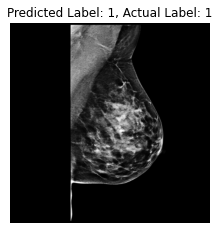

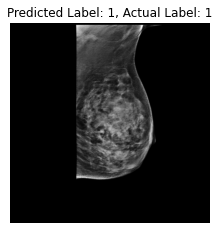

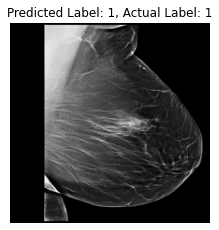

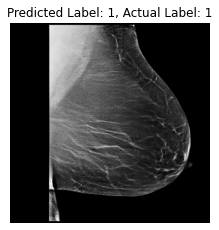

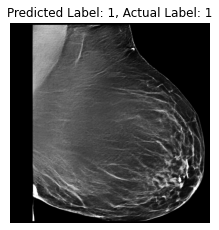

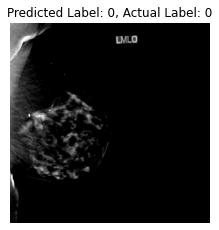

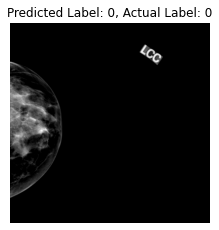

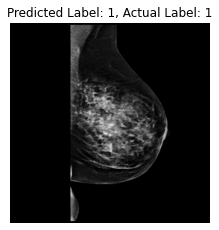

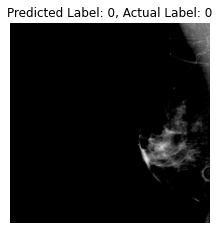

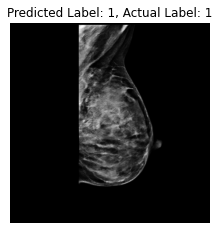

In [22]:
for i in range(10):
    test_sample, test_labels = next(test_generator)
    predictions = model.predict(test_sample)

    # Display the predicted label
    plt.subplot(1, 2, 2)
    predicted_label = np.argmax(predictions[i])
    actual_label = np.argmax(test_labels[i])
    plt.title(f"Predicted Label: {predicted_label}, Actual Label: {actual_label}")
    plt.imshow(test_sample[i], cmap='gray') 
    plt.axis('off')

    plt.tight_layout()
    plt.show()
# 1 for Synthetic and 0 for original